In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [2]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
%matplotlib inline 
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.tree import export_graphviz
import matplotlib.pyplot as plt
import seaborn as sns

import lightgbm as lgbm
import gc
import xgboost as xgb

In [3]:
items           = pd.read_csv('items.csv')
item_categories = pd.read_csv('item_categories.csv')
shops           = pd.read_csv('shops.csv')
sales_train     = pd.read_csv('sales_train_v2.csv')
test            = pd.read_csv('test.csv')
sample_submission            = pd.read_csv('sample_submission.csv')

In [4]:
transactions = sales_train.copy()
transactions[['day','month', 'year']] = transactions['date'].str.split('.', expand=True).astype(int)


In [29]:
w_cat_ids = transactions.set_index('item_id').join(items.set_index('item_id'))
w_cat_ids = w_cat_ids.reset_index()
w_cat_ids['row_id'] = w_cat_ids.index
w_cat_ids['y'] = w_cat_ids.groupby(['date_block_num', 'item_id', 'shop_id'])['item_cnt_day'].transform('sum').clip(0,20)
w_cat_ids = w_cat_ids.drop_duplicates(['date_block_num', 'item_id', 'shop_id'])
w_cat_ids = w_cat_ids[w_cat_ids['year'] != 2013]


In [30]:
w_cat_ids['item_mean'] = w_cat_ids.groupby(['item_id'])['y'].transform('mean')
w_cat_ids['item_mean_month'] = w_cat_ids.groupby(['item_id', 'month'])['y'].transform('mean')
w_cat_ids['shop_mean_month'] = w_cat_ids.groupby(['shop_id', 'month'])['y'].transform('mean')
w_cat_ids['category_mean_month'] = w_cat_ids.groupby(['item_category_id', 'month'])['y'].transform('mean')
w_cat_ids['shop_category_mean_month'] = w_cat_ids.groupby(['shop_id','item_category_id', 'month'])['y'].transform('mean')

In [31]:
X = w_cat_ids[(w_cat_ids['year'] == 2015) | ((w_cat_ids['year'] == 2014) & (w_cat_ids['month'].isin([11,12])))]

In [32]:
rollings = X[['item_mean_month', 'date_block_num', 'item_id']].copy()
rollings = rollings.drop_duplicates(['item_id', 'date_block_num'])
rollings = rollings.set_index(['date_block_num', 'item_id'])
a = rollings.sort_values(['item_id', 'date_block_num'])\
        .groupby(['item_id'])['item_mean_month'].shift(1)

In [33]:
b = pd.DataFrame(a)
b.rename(columns={'item_mean_month': 'item_mean_month_minus_1'}, inplace=True)

X = pd.merge(X, b, on=['item_id', 'date_block_num'], how='left')

In [34]:
rollings = X[['shop_mean_month', 'date_block_num', 'shop_id']].copy()
rollings = rollings.drop_duplicates(['shop_id', 'date_block_num'])
rollings = rollings.set_index(['date_block_num', 'shop_id'])
a = rollings.sort_values(['shop_id', 'date_block_num'])\
        .groupby(['shop_id'])['shop_mean_month'].shift(1)

In [35]:
b = pd.DataFrame(a)
b.rename(columns={'shop_mean_month': 'shop_mean_month_minus_1'}, inplace=True)

X = pd.merge(X, b, on=['shop_id', 'date_block_num'], how='left')

In [39]:
rollings = X[['category_mean_month', 'date_block_num', 'item_category_id']].copy()
rollings = rollings.drop_duplicates(['item_category_id', 'date_block_num'])
rollings = rollings.set_index(['date_block_num', 'item_category_id'])
a = rollings.sort_values(['item_category_id', 'date_block_num'])\
        .groupby(['item_category_id'])['category_mean_month'].shift(1)

In [40]:
b = pd.DataFrame(a)
b.rename(columns={'category_mean_month': 'category_mean_month_minus_1'}, inplace=True)

X = pd.merge(X, b, on=['item_category_id', 'date_block_num'], how='left')

In [42]:
rollings = X[['shop_category_mean_month', 'date_block_num', 'shop_id', 'item_category_id']].copy()
rollings = rollings.drop_duplicates(['item_category_id', 'shop_id', 'date_block_num'])
rollings = rollings.set_index(['date_block_num', 'item_category_id', 'shop_id'])
a = rollings.sort_values(['item_category_id', 'shop_id', 'date_block_num'])\
        .groupby(['item_category_id', 'shop_id'])['shop_category_mean_month'].shift(1)

In [43]:
b = pd.DataFrame(a)
b.rename(columns={'shop_category_mean_month': 'shop_category_mean_month_minus_1'}, inplace=True)

X = pd.merge(X, b, on=['item_category_id', 'shop_id', 'date_block_num'], how='left')

In [36]:
X[X['item_id'] == 30].drop_duplicates(['item_id', 'date_block_num'])[['item_id', 'month', 'year', 'item_mean_month', 'item_mean_month_minus_1']]

,item_id,month,year,item_mean_month,item_mean_month_minus_1,shop_mean_month,shop_mean_month_minus_1
10,30,11,2014,1.300000,NaN,1.911323,NaN
20,30,12,2014,1.600000,1.300000,2.752979,2.294006
30,30,1,2015,1.894737,1.600000,1.843559,2.261371
41,30,2,2015,1.266667,1.894737,1.647494,1.578873
53,30,3,2015,1.714286,1.266667,1.780837,1.892095
58,30,4,2015,1.388889,1.714286,2.224765,2.475191
62,30,5,2015,1.235294,1.388889,1.677648,1.780333
66,30,6,2015,1.133333,1.235294,2.066688,2.071829
70,30,7,2015,1.214286,1.133333,1.553269,1.599356
73,30,8,2015,1.285714,1.214286,1.476230,1.432612


In [37]:
X[X['shop_id'] == 30].drop_duplicates(['shop_id', 'date_block_num'])[['shop_id', 'month', 'year', 'shop_mean_month', 'shop_mean_month_minus_1']]

,shop_id,month,year,shop_mean_month,shop_mean_month_minus_1
11,30,11,2014,1.873958,NaN
35,30,1,2015,1.736099,2.118103
130,30,2,2015,1.670232,1.736099
245,30,12,2014,2.118103,1.873958


In [46]:
X[X['item_category_id'] == 30].drop_duplicates(['item_category_id', 'date_block_num'])[['item_category_id', 'month', 'year', 'category_mean_month', 'category_mean_month_minus_1']]

,item_category_id,month,year,category_mean_month,category_mean_month_minus_1
3762,30,10,2015,3.070205,2.746511
11027,30,1,2015,3.009862,3.101948
11028,30,7,2015,2.670056,2.788012
12837,30,11,2014,2.843284,NaN
12854,30,12,2014,3.101948,2.843284
12897,30,2,2015,2.905608,3.009862
12904,30,3,2015,2.889822,2.905608
12913,30,4,2015,2.892322,2.889822
12925,30,5,2015,2.702312,2.892322
12933,30,6,2015,2.788012,2.702312


In [47]:
X[(X['item_category_id'] == 30) & (X['shop_id'] == 30)].drop_duplicates(['item_category_id', 'shop_id', 'date_block_num'])[['item_category_id', 'shop_id' ,  'month', 'year', 'shop_category_mean_month', 'shop_category_mean_month_minus_1']]

,item_category_id,shop_id,month,year,shop_category_mean_month,shop_category_mean_month_minus_1
16939,30,30,11,2014,1.864198,NaN
16992,30,30,12,2014,2.421687,1.864198
17043,30,30,1,2015,2.597633,2.421687
17087,30,30,2,2015,2.488550,2.597633


In [48]:
X.columns

Index(['item_id', 'date', 'date_block_num', 'shop_id', 'item_price',
       'item_cnt_day', 'day', 'month', 'year', 'item_name', 'item_category_id',
       'row_id', 'y', 'item_mean', 'item_mean_month', 'shop_mean_month',
       'category_mean_month', 'shop_category_mean_month',
       'item_mean_month_minus_1', 'shop_mean_month_minus_1',
       'category_mean_month_minus_1', 'shop_category_mean_month_minus_1'],
      dtype='object')

In [78]:
columns = X.columns
percent_missing = X.isna().sum() * 100 / len(X)
pd.DataFrame({'column_name': columns,
                                 'percent_missing': percent_missing})

,column_name,percent_missing
item_id,item_id,0.000000
date,date,0.000000
date_block_num,date_block_num,0.000000
shop_id,shop_id,0.000000
item_price,item_price,0.000000
item_cnt_day,item_cnt_day,0.000000
day,day,0.000000
month,month,0.000000
year,year,0.000000
item_name,item_name,0.000000


In [51]:
test_w_cat_ids = test.set_index('item_id').join(items.set_index('item_id'))
test_w_cat_ids['item_id'] = test_w_cat_ids.index

In [49]:
#features = ['item_id', 'date_block_num', 'shop_id', #'item_price',
            features = ['item_id', 'shop_id',  'month', 'item_category_id',
       'item_mean', 'item_mean_month', 'shop_mean_month',
       'category_mean_month', 'shop_category_mean_month',
       'item_mean_month_minus_1', 'shop_mean_month_minus_1',
       'category_mean_month_minus_1', 'shop_category_mean_month_minus_1']

In [52]:
# categories test
cat_counts_test = pd.DataFrame(test_w_cat_ids.groupby('item_category_id').size().reset_index(name="counts"))
cat_counts_test['percentage'] = cat_counts_test['counts'] * 100 / cat_counts_test.counts.sum()

# categories train
cat_counts = pd.DataFrame(w_cat_ids.groupby('item_category_id').size().reset_index(name="counts"))
cat_counts['percentage'] = cat_counts['counts'] * 100 / cat_counts.counts.sum()

combined  = pd.merge(cat_counts, cat_counts_test,  how='left', left_on=['item_category_id'], right_on = ['item_category_id'])
combined = combined.rename(index= str, columns={"counts_x": "total_train", "percentage_x": "%train", "counts_y": "total_test", "percentage_y": "%test"})

shares = {}
for _, row in combined.iterrows():
    shares[row['item_category_id']] = row['%test']

no_nans = [v for v in shares.values() if not np.isnan(v)] 
#sorted(no_nans, reverse=True)

val_len = 25000

    
def get_share_of_group(group):
    #print(type(group))
    cat_id = np.unique(group[['item_category_id']])[0]
    share = shares[cat_id]

    #print(share)
    needed = val_len * share / 100
    #print(needed)

    if len(group) <= needed:
        print("Needed %d but only %d available for cat_id %d with share %f" % (needed, len(group), cat_id, share))
    #else:
        #print("OK")
    if np.isnan(needed):
        return group.head(0)
    return group.head(int(needed))


#val_indices = w_cat_ids[w_cat_ids['date_block_num'].isin([32,33])].groupby("item_category_id").apply(get_share_of_group).index
#val_indices = w_cat_ids[w_cat_ids['date_block_num'].isin([32,33])].groupby("item_category_id").apply(get_share_of_group)['row_id'].values

val_indices = X[(X['year'] == 2015) & (X['month'].isin([9,10]))].index

In [53]:
X[features].head()

,item_id,shop_id,month,item_category_id,item_mean,item_mean_month,shop_mean_month,category_mean_month,shop_category_mean_month,item_mean_month_minus_1,shop_mean_month_minus_1,category_mean_month_minus_1,shop_category_mean_month_minus_1
0,2,54,11,40,1.0,1.0,2.355769,1.765038,2.322449,NaN,NaN,NaN,NaN
1,5,54,12,40,1.0,1.0,2.775493,2.074243,2.550369,NaN,2.355769,1.765038,2.322449
2,7,54,12,40,1.0,1.0,2.775493,2.074243,2.550369,NaN,2.355769,1.765038,2.322449
3,10,54,1,40,1.0,1.0,2.479937,1.865802,2.482730,NaN,2.775493,2.074243,2.550369
4,11,54,11,40,1.0,1.0,2.355769,1.765038,2.322449,NaN,NaN,NaN,NaN


In [54]:
x = X[features] 
y = X['y']


x_train = x[~x.index.isin(val_indices)]
y_train = y[~y.index.isin(val_indices)]

x_val = x[x.index.isin(val_indices)]
y_val = y[y.index.isin(val_indices)]

In [62]:
lgtrain = lgbm.Dataset(x_train, label=y_train, categorical_feature=[0,1,2,3])
lgval = lgbm.Dataset(x_val, label=y_val, categorical_feature=[0,1,2,3])



#[0.00542047893814942, 29, 24, 0.39949465609514856, 1, 0.67943500, 10]
params = {
        "num_threads": 8,
        "verbosity": -1,
        #"zero_as_missing": "true",
        "boosting":'gbdt',
        "objective" : "regression",
        "metric" : "rmse",
        "seed": 42,
        #"max_bin": 10,
        #"num_leaves": 10,
        "bagging_fraction": 0.3,
        "bagging_freq": 1,
        "min_data_in_leaf": 5000,
        "feature_fraction": 0.5,
        #"lambda_l2": 3,
        #"max_depth": 2,
        "learning_rate" : 0.01
}

evals_result = {}
model_lgb = lgbm.train(params, lgtrain, 50000, 
                      valid_sets=[lgval], 
                      early_stopping_rounds=100, 
                      verbose_eval=500, 
                      evals_result=evals_result)

/opt/conda/lib/python3.6/site-packages/lightgbm/basic.py:1186: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')
/opt/conda/lib/python3.6/site-packages/lightgbm/basic.py:752: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Training until validation scores don't improve for 100 rounds.
[500]	valid_0's rmse: 1.82288
[1000]	valid_0's rmse: 1.74804
[1500]	valid_0's rmse: 1.7133
[2000]	valid_0's rmse: 1.69171
[2500]	valid_0's rmse: 1.677
[3000]	valid_0's rmse: 1.66603
[3500]	valid_0's rmse: 1.65712
[4000]	valid_0's rmse: 1.65002
[4500]	valid_0's rmse: 1.64357
[5000]	valid_0's rmse: 1.63806
[5500]	valid_0's rmse: 1.63341
[6000]	valid_0's rmse: 1.62954
[6500]	valid_0's rmse: 1.62587
[7000]	valid_0's rmse: 1.62281
[7500]	valid_0's rmse: 1.62021
[8000]	valid_0's rmse: 1.61756
[8500]	valid_0's rmse: 1.61555
[9000]	valid_0's rmse: 1.61403
[9500]	valid_0's rmse: 1.61234
[10000]	valid_0's rmse: 1.61098
[10500]	valid_0's rmse: 1.60907
[11000]	valid_0's rmse: 1.6076
[11500]	valid_0's rmse: 1.60617
[12000]	valid_0's rmse: 1.60477
[12500]	valid_0's rmse: 1.60361
[13000]	valid_0's rmse: 1.60238
[13500]	valid_0's rmse: 1.60148
[14000]	valid_0's rmse: 1.60038
[14500]	valid_0's rmse: 1.59976
[15000]	valid_0's rmse: 1.59885
[

In [83]:
test_w_cat_ids = test.set_index('item_id').join(items.set_index('item_id'))
test_w_cat_ids['item_id'] = test_w_cat_ids.index

In [84]:
test_w_cat_ids['month'] = 11

In [85]:
item_level = X.drop_duplicates(['item_id'])[['item_id','item_mean', 'item_price']]

test_w_cat_ids = pd.merge(test_w_cat_ids, item_level, on=['item_id'], how='left')

/opt/conda/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3265: FutureWarning: 'item_id' is both an index level and a column label.
Defaulting to column, but this will raise an ambiguity error in a future version
  exec(code_obj, self.user_global_ns, self.user_ns)


In [86]:
item_month_level = X[(X.month == 11)].drop_duplicates(['item_id'])[['item_id','item_mean_month']]

test_w_cat_ids = pd.merge(test_w_cat_ids, item_month_level, on=['item_id'], how='left')

In [87]:
item_month_level_ = X[X.month == 10].drop_duplicates(['item_id'])[['item_id','item_mean_month']]\
                                   .copy().rename(columns={'item_mean_month':'item_mean_month_minus_1'})


test_w_cat_ids = pd.merge(test_w_cat_ids, item_month_level_, on=['item_id'], how='left')

In [88]:
shop_month_level_ = X[(X.month == 11)].drop_duplicates(['shop_id'])[['shop_id','shop_mean_month']]

test_w_cat_ids = pd.merge(test_w_cat_ids, shop_month_level_, on=['shop_id'], how='left')

In [89]:
shop_month_level_ = X[X.month == 10].drop_duplicates(['shop_id'])[['shop_id','shop_mean_month']]\
                                   .copy().rename(columns={'shop_mean_month':'shop_mean_month_minus_1'})


test_w_cat_ids = pd.merge(test_w_cat_ids, shop_month_level_, on=['shop_id'], how='left')

In [90]:
cat_month_level_ = X[(X.month == 11)].drop_duplicates(['item_category_id'])[['item_category_id','category_mean_month']]

test_w_cat_ids = pd.merge(test_w_cat_ids, cat_month_level_, on=['item_category_id'], how='left')

In [91]:
cat_month_level_ = X[X.month == 10].drop_duplicates(['item_category_id'])[['item_category_id','category_mean_month']]\
                                   .copy().rename(columns={'category_mean_month':'category_mean_month_minus_1'})


test_w_cat_ids = pd.merge(test_w_cat_ids, cat_month_level_, on=['item_category_id'], how='left')

In [92]:
shop_cat_month_level_ = X[(X.month == 11)].drop_duplicates(['item_category_id', 'shop_id'])[['item_category_id', 'shop_id', 'shop_category_mean_month']]

test_w_cat_ids = pd.merge(test_w_cat_ids, shop_cat_month_level_, on=['item_category_id', 'shop_id'], how='left')

In [93]:
shop_cat_month_level_ = X[X.month == 10].drop_duplicates(['item_category_id', 'shop_id'])[['item_category_id', 'shop_id', 'shop_category_mean_month']]\
                                   .copy().rename(columns={'shop_category_mean_month':'shop_category_mean_month_minus_1'})


test_w_cat_ids = pd.merge(test_w_cat_ids, shop_cat_month_level_, on=['item_category_id', 'shop_id'], how='left')

In [47]:
test_w_cat_ids['item_mean_month'] = test_w_cat_ids['item_mean_month'].fillna(test_w_cat_ids['quarter_mean'])

In [95]:
test_w_cat_ids[features].head()

,item_id,shop_id,month,item_category_id,item_mean,item_mean_month,shop_mean_month,category_mean_month,shop_category_mean_month,item_mean_month_minus_1,shop_mean_month_minus_1,category_mean_month_minus_1,shop_category_mean_month_minus_1
0,30,5,11,40,1.447115,1.3,1.767978,1.765038,1.342282,1.555556,1.688486,1.713469,1.446903
1,30,4,11,40,1.447115,1.3,1.879365,1.765038,1.129032,1.555556,1.618246,1.713469,1.270270
2,30,6,11,40,1.447115,1.3,2.093153,1.765038,1.603774,1.555556,1.927950,1.713469,1.446328
3,30,3,11,40,1.447115,1.3,1.865922,1.765038,1.421053,1.555556,1.657799,1.713469,1.279661
4,30,2,11,40,1.447115,1.3,2.282407,1.765038,1.228571,1.555556,1.867836,1.713469,1.264151


In [96]:
columns = X.columns
percent_missing = X.isna().sum() * 100 / len(X)
pd.DataFrame({'column_name': columns,
                                 'percent_missing': percent_missing})

,column_name,percent_missing
item_id,item_id,0.000000
date,date,0.000000
date_block_num,date_block_num,0.000000
shop_id,shop_id,0.000000
item_price,item_price,0.000000
item_cnt_day,item_cnt_day,0.000000
day,day,0.000000
month,month,0.000000
year,year,0.000000
item_name,item_name,0.000000


In [97]:
columns = test_w_cat_ids.columns
percent_missing = test_w_cat_ids.isna().sum() * 100 / len(test_w_cat_ids)
pd.DataFrame({'column_name': columns,
                                 'percent_missing': percent_missing})

,column_name,percent_missing
ID,ID,0.000000
shop_id,shop_id,0.000000
item_name,item_name,0.000000
item_category_id,item_category_id,0.000000
item_id,item_id,0.000000
month,month,0.000000
item_mean,item_mean,8.843137
item_price,item_price,8.843137
item_mean_month,item_mean_month,51.509804
item_mean_month_minus_1,item_mean_month_minus_1,21.745098


In [98]:
preds = model_lgb.predict(test_w_cat_ids[features])
preds.clip(0,20,out=preds)

array([ 1.06746694,  1.0502823 ,  1.02596287, ...,  1.31975163,
        1.02967604,  1.20213873])

In [99]:
submission = test.loc[:,['ID']]
submission['item_cnt_month'] = preds.astype(int)

submission.to_csv('submission.csv', index=False)

Plotting feature importances...


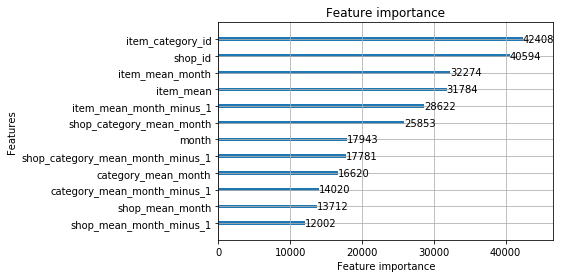

In [63]:
print('Plotting feature importances...')
ax = lgbm.plot_importance(model_lgb, max_num_features=20)
plt.show()

3.45 val > 3.70 submit
3.06 val > 3.65 submit